### Time Series Changes and Versioning with TimeDB

This notebook demonstrates how to manually change values, tags, and annotations of a time series and view all versions of the changes.

#### What you'll learn:
1. **Creating and inserting a time series** - Insert initial time series data as overlappin
2. **Reading and visualizing time series** - Read and plot the original data
3. **Updating time series** - Manually change values, tags, and annotations
4. **Reading all versions** - Query all versions of the time series using `versions=True`
5. **Visualizing changes** - Plot original vs updated versions to see the differences
6. **Batch updates and version history** - Update multiple values and view complete version history

**Key Concepts:**
- Updates only apply to **overlapping** (flat values are immutable facts)
- TimeDB maintains a full version history of all changes via `known_time` versioning
- Each update creates a new version (new row with new `known_time`) while keeping the old version for audit trail
- The `versions=True` flag allows you to see all historical versions with `known_time` as an index level
- Updates use a key-based approach: `(batch_id, tenant_id, valid_time, series_id)`
- Updates can modify values, annotations, and tags independently or together

In [1]:
from timedb import TimeDataClient
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta
import numpy as np
from dotenv import load_dotenv
load_dotenv()

# Use the TimeDataClient to interact with TimeDB
td = TimeDataClient()

# Reset database (create/delete schema)
td.delete()
td.create()

Creating database schema...
✓ Schema created successfully


## Part 1: Insert a Time Series

First, let's insert an initial time series.


In [ ]:
# Create a time series with hourly data for 24 hours
base_time = datetime(2025, 1, 1, 0, 0, tzinfo=timezone.utc)
times = [base_time + timedelta(hours=i) for i in range(24)]

# Generate sample data: temperature values with a daily pattern
np.random.seed(42)
base_temp = 20.0
amplitude = 5.0
temperature_values = [
    base_temp + amplitude * np.sin(2 * np.pi * i / 24) + np.random.normal(0, 0.5)
    for i in range(24)
]
temperature_values = [round(v, 2) for v in temperature_values]

# Create DataFrame
df = pd.DataFrame({
    'valid_time': times,
    'temperature': temperature_values
})

# Create the series as overlapping so we can update it later
# (updates only work on overlapping, not flat)
if td.series("temperature").count() == 0:
    td.create_series(name="temperature", unit="dimensionless", data_class="overlapping")

# Insert the time series
result = td.series("temperature").insert(df=df, known_time=base_time)

print(f"Inserted {len(df)} data points")
print(f"  Batch ID: {result.batch_id}")
print(f"  Series ID: {result.series_ids['temperature']}")
print(f"  Time range: {times[0]} to {times[-1]}")

# Store IDs for later use
batch_id = result.batch_id
tenant_id = result.tenant_id
series_id = result.series_ids['temperature']

Inserted 24 data points
  Batch ID: bbb7464c-3c3f-4161-b81f-b48a30f37c95
  Series ID: c77256ed-a7cb-40f1-96e1-1acab30b5e22
  Time range: 2025-01-01 00:00:00+00:00 to 2025-01-01 23:00:00+00:00


## Part 2: Read and Plot the Original Time Series

Now let's read back the time series and visualize it.

In [3]:
# Read the time series
df_read = td.series("temperature").read(
    start_valid=base_time,
    end_valid=base_time + timedelta(hours=24),
)

print(f"Read {len(df_read)} data points")
print(f"\nDataFrame shape: {df_read.shape}")
print(f"\nColumns: {list(df_read.columns)}")
print(f"\nFirst few rows:")
df_read.head(10)

Read 24 data points

DataFrame shape: (24, 1)

Columns: ['temperature']

First few rows:


name,temperature
valid_time,
2025-01-01 00:00:00+00:00,20.25
2025-01-01 01:00:00+00:00,21.22
2025-01-01 02:00:00+00:00,22.82
2025-01-01 03:00:00+00:00,24.3
2025-01-01 04:00:00+00:00,24.21
2025-01-01 05:00:00+00:00,24.71
2025-01-01 06:00:00+00:00,25.79
2025-01-01 07:00:00+00:00,25.21
2025-01-01 08:00:00+00:00,24.1


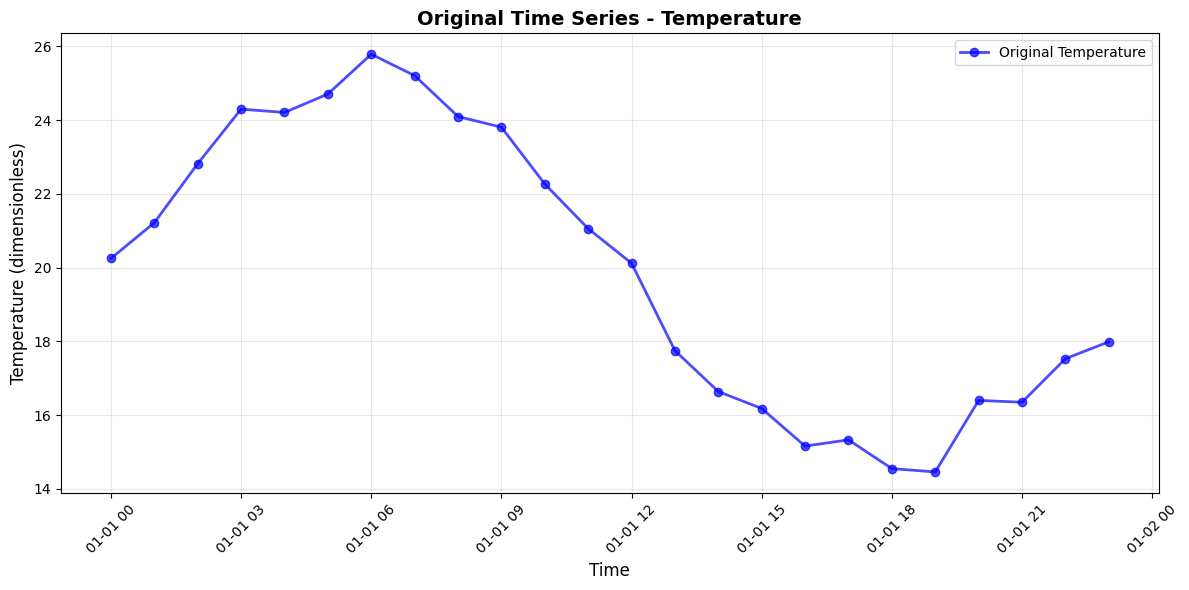

✓ Original time series plotted successfully!


In [4]:
# Plot the original time series
plt.figure(figsize=(12, 6))

# Use plain numeric values (dimensionless) for plotting
y_vals = df_read['temperature'].astype(float)
plt.plot(df_read.index, y_vals, marker='o', linewidth=2, markersize=6, 
         label='Original Temperature', color='blue', alpha=0.7)

plt.xlabel('Time', fontsize=12)
plt.ylabel('Temperature (dimensionless)', fontsize=12)
plt.title('Original Time Series - Temperature', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("✓ Original time series plotted successfully!")

## Part 3: Update the Time Series

Now we'll make an update to change a value, add a tag, and add an annotation.
We'll update the value at hour 2 (early in the series) to correct what appears to be an anomalous reading.

**Note**: Updates use a key-based approach with `(batch_id, tenant_id, valid_time, series_id)`.
The `batch_id` and `series_id` come from the insert result.

In [ ]:
# The time point we want to update (hour 2)
update_time = base_time + timedelta(hours=2)

# Get the original value for reference
original_value = float(df_read.loc[update_time, 'temperature'])
print(f"Original value at {update_time}: {original_value:.2f}")

# Create an update that:
# 1. Changes the value to a corrected temperature
# 2. Adds an annotation explaining the correction
# 3. Adds tags to mark this as reviewed and corrected
corrected_value = 24.5

print(f"\nUpdating to: {corrected_value:.2f}")
print(f"Adding annotation: 'Manual correction: sensor reading was anomalous'")
print(f"Adding tags: ['reviewed', 'corrected']")

# Create the update record using the key-based approach
record_update = {
    "batch_id": batch_id,
    "tenant_id": tenant_id,
    "valid_time": update_time,
    "series_id": series_id,
    "value": corrected_value,
    "annotation": "Manual correction: sensor reading was anomalous",
    "tags": ["reviewed", "corrected"],
    "changed_by": "analyst@example.com",
}

# Execute the update
result = td.update_records(updates=[record_update])

print(f"\nUpdate completed!")
print(f"  Updated records: {len(result['updated'])}")
print(f"  Skipped (no-op): {len(result['skipped_no_ops'])}")
if result['updated']:
    print(f"  New overlapping_id: {result['updated'][0]['overlapping_id']}")

Original value at 2025-01-01 02:00:00+00:00: 22.82

Updating to: 24.50
Adding annotation: 'Manual correction: sensor reading was anomalous'
Adding tags: ['reviewed', 'corrected']


UndefinedColumn: column "projection_id" does not exist
LINE 2:         SELECT projection_id, value, valid_time_end, annotat...
                       ^

## Part 4: Read All Versions of the Time Series

Now let's read the time series again, but this time with `versions=True` to see both the original version and the updated version. Each version has a different `known_time`.

In [ ]:
# Read with versions=True to get all versions (original and updated)
df_all_versions = td.series("temperature").read(
    start_valid=base_time,
    end_valid=base_time + timedelta(hours=24),
    versions=True,
)

print(f"Read {len(df_all_versions)} data points (including all versions)")
print(f"\nDataFrame shape: {df_all_versions.shape}")
print(f"\nColumns: {list(df_all_versions.columns)}")
if isinstance(df_all_versions.index, pd.MultiIndex):
    print(f"\nIndex: MultiIndex with levels {df_all_versions.index.names}")
else:
    print(f"\nIndex: {df_all_versions.index.name}")
print(f"\nNote: With versions=True, we get both current and historical versions.")
print(f"      Each version has a different known_time in the index.")
print(f"\nFirst few rows:")
df_all_versions.head(15)

## Part 5: Plot Original vs Updated Time Series

Now let's plot both the original and updated versions to visualize the change.


In [ ]:
# Read current version (default behavior - latest known_time per valid_time)
df_current = td.series("temperature").read(
    start_valid=base_time,
    end_valid=base_time + timedelta(hours=24),
)

# Use the original read for comparison
df_original_plot = df_read.copy()

# Convert to numeric arrays for plotting (dimensionless, plain floats)
orig_y = df_original_plot['temperature'].astype(float)
current_y = df_current['temperature'].astype(float)

# Plot both versions
plt.figure(figsize=(14, 7))

plt.plot(df_original_plot.index, orig_y, 
         marker='o', linewidth=2, markersize=6, 
         label='Original Time Series', color='blue', alpha=0.6, linestyle='--')

plt.plot(df_current.index, current_y, 
         marker='s', linewidth=2, markersize=6, 
         label='Updated Time Series (Current)', color='red', alpha=0.8)

# Highlight the updated point
if update_time in df_current.index:
    updated_value = float(current_y.loc[update_time])
    original_value_at_update = float(orig_y.loc[update_time])
    
    plt.axvline(x=update_time, color='green', linestyle=':', linewidth=2, alpha=0.7, label='Update Point')
    
    plt.annotate(
        f'Updated: {original_value_at_update:.2f} -> {updated_value:.2f}',
        xy=(update_time, updated_value),
        xytext=(10, 20),
        textcoords='offset points',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'),
        fontsize=10,
        fontweight='bold'
    )

plt.xlabel('Time', fontsize=12)
plt.ylabel('Temperature (dimensionless)', fontsize=12)
plt.title('Original vs Updated Time Series - Showing the Change', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Comparison plot created successfully!")
print(f"\nKey observation:")
print(f"  - The original time series (blue dashed line) shows the initial values")
print(f"  - The updated time series (red solid line) shows the corrected value at hour 2")
print(f"  - The green dotted line marks the point where the update was made")

**Note:** Use `td.series("<name>").read(versions=True)` to retrieve all versions for a series. Each version has a different `known_time` in the multi-index.

## Part 6: Update Multiple Values and View All Versions

Now let's update multiple values (including the one we already updated) and then display all versions of these values in a pandas DataFrame.


In [ ]:
# Read the current time series to get values for multiple updates
df_current = td.series("temperature").read(
    start_valid=base_time,
    end_valid=base_time + timedelta(hours=24),
)

# Convert temperature column to numeric for arithmetic
current_temp_mag = df_current['temperature'].astype(float)

# Define multiple time points to update (including the one we already updated at hour 2)
update_times = [
    base_time + timedelta(hours=2),  # Already updated, will update again
    base_time + timedelta(hours=3),  # New update
    base_time + timedelta(hours=4),  # New update
]

# Prepare update records for all time points
updates = []
for ut in update_times:
    if ut in df_current.index:
        original_value = current_temp_mag.loc[ut]
        new_value = float(original_value) + 2.0  # Add 2 to each value
        
        update_record = {
            "batch_id": batch_id,
            "tenant_id": tenant_id,
            "valid_time": ut,
            "series_id": series_id,
            "value": new_value,
            "annotation": f"Batch correction: adjusted temperature by +2.0",
            "tags": ["batch_corrected", "reviewed"],
            "changed_by": "batch_processor@example.com",
        }
        updates.append(update_record)
        print(f"Prepared update for {ut}: {original_value:.2f} -> {new_value:.2f}")

# Execute all updates
if updates:
    result = td.update_records(updates=updates)
    print(f"\nBatch update completed!")
    print(f"  Updated records: {len(result['updated'])}")
    print(f"  Skipped (no-op): {len(result['skipped_no_ops'])}")
else:
    print("No updates to perform")

In [ ]:
# Read all versions of the updated time points
df_all_versions = td.series("temperature").read(
    start_valid=base_time + timedelta(hours=1),
    end_valid=base_time + timedelta(hours=6),
    versions=True,
)

print("All versions of the updated time points:")
print("=" * 100)
print(f"\nDataFrame shape: {df_all_versions.shape}")
print(f"\nColumns: {list(df_all_versions.columns)}")
print(f"\nIndex type: {type(df_all_versions.index)}")
if isinstance(df_all_versions.index, pd.MultiIndex):
    print(f"Index levels: {df_all_versions.index.names}")
print("\n" + "=" * 100)

# Display the DataFrame - each version has a different known_time
df_all_versions

## Summary

This notebook demonstrated:

1. **Creating and inserting a time series**: Using `td.create_series(data_class='overlapping')` and `td.series("temperature").insert()` to create versioned time series data

2. **Reading time series**: Using `td.series("temperature").read()` to retrieve the latest values (by `known_time`)

3. **Updating time series**: Using `td.update_records()` with key-based updates `(batch_id, tenant_id, valid_time, series_id)` to change:
   - **Values**: Correcting erroneous data points
   - **Tags**: Adding quality flags (e.g., "reviewed", "corrected")
   - **Annotations**: Adding explanatory notes about the changes

4. **Reading all versions**: Using `read(versions=True)` to retrieve all versions with `known_time` as an index level

5. **Visualizing changes**: Plotting original vs updated versions to see the differences

6. **Batch updates and version history**: Updating multiple values and viewing complete version history

**Key Takeaways:**
- Updates only work on **overlapping** (flat values are immutable facts)
- TimeDB maintains a complete version history via `known_time` versioning
- Each update creates a new row with a new `known_time` while preserving the old row
- The `versions=True` flag returns all versions with `(known_time, valid_time)` multi-index
- The latest value is determined by the most recent `known_time`
- Updates use a key-based approach: `(batch_id, tenant_id, valid_time, series_id)`
- Updates can modify values, annotations, and tags independently or together